## 0. Preprocessing Data

In [4]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import surprise

In [5]:
# Master Dataset
df = pd.read_csv('df_mapped_final.csv')
df.reset_index(inplace = True)
df.drop(['index', 'Unnamed: 0'], axis = 1, inplace = True)

In [6]:
df.head(5)

,whiskey_name,name,rating,whiskey_id,user_id
0,"10th Mountain ""Colorado Clear"" Mountain Moonshine",ErikWachtmeister,4.0,1,1
1,"10th Mountain ""Colorado Clear"" Mountain Moonshine",buffalol20,4.0,1,2
2,"10th Mountain ""Colorado Clear"" Mountain Moonshine",dkblattner,3.0,1,3
3,10th Mountain Bourbon,Andrew-Denniger,4.0,2,4
4,10th Mountain Bourbon,Bernie-Wing,5.0,2,5


In [7]:
# Mean rating is around 3.75. The rating dataset skews left. 
df['rating'].describe()

count    428472.000000
mean          3.746347
std           0.903495
min           0.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

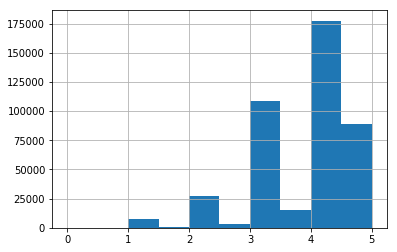

In [8]:
# We can see that our rating dataset is significantly skewed
%matplotlib inline
plt.hist(df['rating'])
plt.grid(True)
plt.show()

In [9]:
# There are values falling outside of the 0.25 intervals 
# Because we aggregate ratings of people rating the same items more than once 
df.groupby('rating')['name'].count()

rating
0.000000       30
0.250000       58
0.500000       89
0.625000        2
0.750000       43
0.875000        1
1.000000     7059
1.125000        3
1.208333        1
1.250000       77
1.333333        1
1.375000        1
1.416667        1
1.500000      305
1.625000        2
1.666667        3
1.750000      176
1.833333        1
1.875000        9
1.916667        1
2.000000    26714
2.083333        1
2.125000        6
2.166667        1
2.250000      483
2.333333        7
2.375000       17
2.416667        1
2.458333        1
2.500000     1736
            ...  
4.285714        2
4.291667        2
4.300000        1
4.312500        5
4.333333       61
4.350000        1
4.375000      183
4.416667       18
4.444444        1
4.500000     6657
4.541667        1
4.550000        1
4.562500        2
4.583333       14
4.600000        3
4.625000      151
4.650000        1
4.666667       47
4.687500        3
4.708333        1
4.714286        1
4.750000     2062
4.800000        1
4.812500        2
4.8

In [10]:
whiskeys = pd.read_csv('whiskey_data_new_final_for_KNN.csv')
whiskeys.drop('Index', axis = 1, inplace = True)

whiskey_set1 = set(df['whiskey_name'])
whiskey_set2 = set(whiskeys['whiskey_name'])
whiskey_set = whiskey_set1 & whiskey_set2
df = df.loc[df.whiskey_name.isin(whiskey_set)].reset_index()
df.drop('index', axis = 1, inplace = True)
whiskeys = whiskeys.loc[whiskeys.whiskey_name.isin(whiskey_set)].reset_index()
whiskeys.drop('index', axis = 1, inplace = True)

In [11]:
print(df.shape)
print(whiskeys.shape)

(428472, 5)
(2330, 28)


In [12]:
whiskey_dict = dict(set([i for i in zip(df['whiskey_name'], df['whiskey_id'])]))
user_dict = dict(set([i for i in zip(df['name'], df['user_id'])]))
whiskeys = whiskeys.assign(whiskey_id=whiskeys['whiskey_name'].map(whiskey_dict))
whiskeys.whiskey_id = whiskeys.whiskey_id.astype(int)

In [13]:
# Reverse the dictionary for prediction task below
whiskey_dict = dict(set([i for i in zip(df['whiskey_id'], df['whiskey_name'])]))
user_dict = dict(set([i for i in zip(df['user_id'], df['name'])]))

## 1. Build Collaborative Filtering Recommendation Systems with Surprise

In [14]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import SVDpp
from surprise import SVD
from surprise import NMF
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [15]:
# Choose a subset of the dataset (5%) due to computational limitations
df2 = df.sample(frac=0.05, random_state = 1)
df2.shape

(21424, 5)

### 1.1 KNN USER-BASED

In [13]:
# Prepare the data for the Reader()
df2 = df2[['user_id', 'whiskey_id', 'rating']]

#### TRAIN THE MODEL

In [176]:
# First, we use KNNWithMeans with a pearson_baseline
reader = Reader()
data = Dataset.load_from_df(df2, reader)
trainingSet = data.build_full_trainset()

In [126]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainingSet)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


#### HYPERPARAMETER TUNING

In [77]:
from surprise.model_selection.search import GridSearchCV
param_grid = {'k': [10, 20, 30, 40, 50], # k: The (max) number of neighbors to take into account for aggregation
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'min_support': [1, 2, 3, 4, 5], # The minimum number of common items
                              'user_based': [True]}}

gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1)
gs_knn.fit(data) # data here is basically the training set
# best RMSE score
print(gs_knn.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs_knn.best_params['rmse'])
print(gs_knn.best_params)

0.9764748435198278
{'k': 40, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}
{'rmse': {'k': 40, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}, 'mae': {'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 1, 'user_based': True}}}


#### CROSS VALIDATION

In [78]:
from surprise.model_selection.validation import cross_validate
cv = cross_validate(KNNWithMeans(k = 40, sim_options={'name': 'msd', 'min_support': 1, 'user_based': True}),
               data, measures=[u'rmse', u'mae'], cv=10,
               verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0087  0.9779  0.9853  0.9498  0.9651  0.9864  0.9807  0.9731  0.9673  0

#### PREDICTIONS

In [16]:
def get_top_recommendations(algo, input_file_name):
    from surprise import KNNWithMeans
    from surprise import Dataset
    from surprise import Reader
    
    input_ = pd.read_csv(input_file_name)
    input_whiskey = list(input_['whiskey_id'])
    input_rating = list(input_['rating'])
    
    # When somebody enters 10 ratings for 10 whiskeys
    new_user_id = df2['user_id'].max() + 1 # create new user_id for that person
    input_data = pd.DataFrame({'user_id': [new_user_id]*10, # create a new dataframe for that person
                               'whiskey_id': input_whiskey,
                               'rating': input_rating
        
    })
    df3 = [df2, input_data]
    df3 = pd.concat(df3) # concat that dataframe into the new training set
    df3.reset_index(inplace = True)
    df3.drop('index', axis = 1, inplace = True)
    
    #KNN algorithm
    reader = Reader()
    data = Dataset.load_from_df(df3[['user_id', 'whiskey_id', 'rating']], reader)
    trainingSet = data.build_full_trainset()
    # algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True}) # change algorithm for this
    algo.fit(trainingSet)
    
    # Create test set
    chosen_whiskey = list(df2['whiskey_id'])
    pred_whiskey = list(set(chosen_whiskey) - set(input_whiskey))
    pred_user = [new_user_id]*len(pred_whiskey)
    pred_true_rating = [df3['rating'].mean()]*len(pred_whiskey)
    testSet = [i for i in zip(pred_user, pred_whiskey, pred_true_rating)]
    
    # Predictions
    predictions = algo.test(testSet)
    # Recommendations
    from collections import defaultdict
    
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((whiskey_dict[iid], est))
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:10] # Recommend 10 whiskeys
    
    return [i[0] for i in dict(top_recs)[uid]]

In [17]:
input_file_name = 'user_input_set.csv' 
knn_user = KNNWithMeans(k = 40, sim_options={'name': 'msd', 'min_support': 1, 'user_based': True})
get_top_recommendations(knn_user, input_file_name)

Computing the msd similarity matrix...
Done computing similarity matrix.


['Knob Creek Cask Strength Straight Rye',
 'Glenfarclas 12 Year',
 'Oban 14 Year',
 'Pappy Van Winkle Family Reserve 15 Year',
 'The Macallan 18 Year Sherry Oak Cask',
 'Willett Family Estate Bottled Rye 4 Year',
 'Auchentoshan American Oak',
 'Glenmorangie Astar',
 'Nikka Miyagikyo Single Malt',
 'The Balvenie Doublewood 12 Year']

### 1.2 KNN ITEM-BASED EVALUATION

#### HYPERPARAMETER TUNING

In [79]:
param_grid = {'k': [10, 20, 30, 40, 50], # k: The (max) number of neighbors to take into account for aggregation
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'min_support': [1, 2, 3, 4, 5], # The minimum number of common items
                              'user_based': [False]}}

gs_knn_item = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn_item.fit(data) # data here is basically the training set
# best RMSE score
print(gs_knn_item.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs_knn_item.best_params['rmse'])
print(gs_knn_item.best_params)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline simil

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0.8631075049317051
{'k': 10, 'sim_options': {'name': 'pearson_baseline', 'min_support': 4, 'use

#### CROSS-VALIDATION

In [80]:
# Seems like item-based KNN performs better than user-based KNN
cv_knn_item = cross_validate(KNNWithMeans(k = 10, sim_options={'name': 'pearson_baseline', 'min_support': 4, 'user_based': False}),
               data, measures=[u'rmse', u'mae'], cv=10,
               verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

#### PREDICTIONS

In [18]:
input_file_name = 'user_input_set.csv' 
knn_item = KNNWithMeans(k = 10, sim_options={'name': 'pearson_baseline', 'min_support': 4, 'user_based': False})
get_top_recommendations(knn_item, input_file_name)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


['Alley 6 Rye Whiskey',
 'Amrut Peated Indian Single Malt',
 'Amrut Portonova Single Malt',
 'Antiquary 12 Year',
 'Ardbeg 17 Year',
 'Arran 17 Year',
 'Arran Smuggler Series The Illicit Stills Vol. 1',
 'Auchentoshan 21 Year',
 'Balblair 1983 1st Release ',
 'Balblair 1990 2nd Release']

### 1.3 SVD

#### HYPERPARAMETER TUNING

In [81]:
param_grid = {'n_factors': [110, 130, 160], 
              'n_epochs': [90, 110], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.15]}

gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs_svd.fit(data)

algo = gs_svd.best_estimator['rmse']
print(gs_svd.best_score['rmse'])
print(gs_svd.best_params['rmse'])
print(gs_svd.best_params)

0.8097618870524951
{'n_factors': 110, 'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.15}
{'rmse': {'n_factors': 110, 'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.15}, 'mae': {'n_factors': 110, 'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.15}}


#### CROSS VALIDATION

In [82]:
cross_validate(SVD(n_factors = 110, n_epochs = 90, lr_all = 0.005, reg_all = 0.15),
               data, measures=[u'rmse', u'mae'], cv=10,
               verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8188  0.8093  0.8188  0.7943  0.8329  0.7656  0.7997  0.8007  0.7986  0.8145  0.8053  0.0174  
MAE (testset)     0.6213  0.6259  0.6331  0.6136  0.6482  0.5920  0.6239  0.6220  0.6202  0.6279  0.6228  0.0135  
Fit time          5.75    5.42    5.47    5.45    5.42    5.47    5.44    5.42    5.46    5.42    5.47    0.09    
Test time         0.01    0.02    0.01    0.02    0.01    0.02    0.01    0.01    0.01    0.02    0.01    0.00    


{'test_rmse': array([0.81875272, 0.80934371, 0.81883835, 0.79433394, 0.8328682 ,
        0.76563959, 0.79971592, 0.8007419 , 0.79856697, 0.81453145]),
 'test_mae': array([0.62132756, 0.62593204, 0.63312755, 0.61359546, 0.64820913,
        0.59198066, 0.62392466, 0.6219677 , 0.62015106, 0.62794055]),
 'fit_time': (5.748585224151611,
  5.420328855514526,
  5.472946882247925,
  5.454653978347778,
  5.416581153869629,
  5.467586040496826,
  5.439211130142212,
  5.421974182128906,
  5.460716962814331,
  5.421677827835083),
 'test_time': (0.014637947082519531,
  0.015257835388183594,
  0.014603853225708008,
  0.015017986297607422,
  0.014658927917480469,
  0.015241861343383789,
  0.014509201049804688,
  0.014986991882324219,
  0.014467716217041016,
  0.015035152435302734)}

#### PREDICTIONS

In [19]:
input_file_name = 'user_input_set.csv'
svd = SVD(n_factors = 110, n_epochs = 90, lr_all = 0.005, reg_all = 0.15)
get_top_recommendations(svd, input_file_name)

['George T. Stagg Bourbon (Fall 2017)',
 'Kavalan Solist Vinho Barrique Single Cask Strength ',
 "Parker's Heritage Promise of Hope",
 'Colonel E.H. Taylor, Jr. Four Grain Bottled-in-Bond',
 'Laphroaig 32 Year ',
 'Pappy Van Winkle 20 Year',
 'William Larue Weller Bourbon (Fall 2015)',
 'The Macallan Rare Cask ',
 'Lagavulin Distillers Edition',
 'Four Roses Limited Edition Small Batch Bourbon (2015)']

### 1.4 SVD++

#### HYPERPARAMETER TUNING

In [83]:
param_grid = {'n_factors': [110, 130, 160], 
              'n_epochs': [90, 110], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.15]}

gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs_svdpp.fit(data)

algo = gs_svdpp.best_estimator['rmse']
print(gs_svdpp.best_score['rmse'])
print(gs_svdpp.best_params['rmse'])
print(gs_svdpp.best_params)

0.8176061520033605
{'n_factors': 110, 'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.15}
{'rmse': {'n_factors': 110, 'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.15}, 'mae': {'n_factors': 110, 'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.15}}


#### CROSS VALIDATION

In [84]:
cross_validate(SVDpp(n_factors = 110, n_epochs = 90, lr_all = 0.005, reg_all = 0.15),
               data, measures=[u'rmse', u'mae'], cv=10,
               verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8291  0.8124  0.8133  0.8022  0.7926  0.8262  0.7970  0.8161  0.7982  0.8259  0.8113  0.0126  
MAE (testset)     0.6398  0.6339  0.6329  0.6227  0.6189  0.6387  0.6159  0.6410  0.6136  0.6377  0.6295  0.0101  
Fit time          20.90   20.86   20.98   21.01   20.83   21.19   21.02   21.05   20.94   21.08   20.99   0.10    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.00    


{'test_rmse': array([0.82906655, 0.81242193, 0.81331612, 0.80219032, 0.79264384,
        0.82624096, 0.79702988, 0.81612359, 0.79819815, 0.82587159]),
 'test_mae': array([0.63977273, 0.63391031, 0.63285973, 0.62269371, 0.61893343,
        0.63865548, 0.61590692, 0.64097867, 0.61362728, 0.63771287]),
 'fit_time': (20.899518966674805,
  20.860366106033325,
  20.983689785003662,
  21.013669967651367,
  20.827924013137817,
  21.1859610080719,
  21.018309116363525,
  21.048537731170654,
  20.93875789642334,
  21.080537796020508),
 'test_time': (0.025869131088256836,
  0.029565811157226562,
  0.026173830032348633,
  0.025570154190063477,
  0.025906801223754883,
  0.02565598487854004,
  0.025543928146362305,
  0.02553272247314453,
  0.025207996368408203,
  0.03000807762145996)}

#### PREDICTIONS

In [20]:
input_file_name = 'user_input_set.csv'
svdpp = SVDpp(n_factors = 110, n_epochs = 90, lr_all = 0.005, reg_all = 0.15)
get_top_recommendations(svdpp, input_file_name)

['George T. Stagg Bourbon (Fall 2017)',
 'Pappy Van Winkle 23 Year',
 'Pappy Van Winkle 20 Year',
 'The Macallan Rare Cask ',
 'Bruichladdich Black Art 1990 04.1 Edition',
 'Lagavulin Distillers Edition',
 "Booker's Rye Whiskey Big Time Batch (2016 Release)",
 "Parker's Heritage Promise of Hope",
 'Four Roses Limited Edition Small Batch Bourbon (2015)',
 'Laphroaig 15 Year 200th Anniversary ']

### 1.5 NMF

#### HYPERPARAMETER TUNING

In [85]:
param_grid = {'n_factors': [110, 130, 160], 
              'n_epochs': [90, 110, 130]}

gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
gs_nmf.fit(data)

algo = gs_nmf.best_estimator['rmse']
print(gs_nmf.best_score['rmse'])
print(gs_nmf.best_params['rmse'])
print(gs_nmf.best_params)

0.943679134840858
{'n_factors': 160, 'n_epochs': 90}
{'rmse': {'n_factors': 160, 'n_epochs': 90}, 'mae': {'n_factors': 160, 'n_epochs': 90}}


#### CROSS VALIDATION

In [86]:
cross_validate(NMF(n_factors = 160, n_epochs = 90),
               data, measures=[u'rmse', u'mae'], cv=10,
               verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9444  0.9301  0.9382  0.9545  0.9572  0.9348  0.9440  0.9379  0.9170  0.9334  0.9392  0.0111  
MAE (testset)     0.7432  0.7198  0.7338  0.7459  0.7597  0.7395  0.7357  0.7352  0.7186  0.7240  0.7355  0.0120  
Fit time          21.48   21.69   21.38   21.23   21.26   22.59   22.32   22.60   22.65   21.59   21.88   0.56    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.02    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.9444436 , 0.93008308, 0.93817473, 0.9545112 , 0.95721827,
        0.93484447, 0.94401191, 0.9378801 , 0.91703678, 0.93335423]),
 'test_mae': array([0.74324341, 0.71982326, 0.73377065, 0.74586306, 0.75972532,
        0.73946708, 0.73566034, 0.73524214, 0.71861763, 0.72395006]),
 'fit_time': (21.484656810760498,
  21.689722061157227,
  21.37691307067871,
  21.234088897705078,
  21.259886264801025,
  22.59340476989746,
  22.318750143051147,
  22.602141857147217,
  22.646140813827515,
  21.593103885650635),
 'test_time': (0.014259099960327148,
  0.013804912567138672,
  0.01353907585144043,
  0.014602184295654297,
  0.013637781143188477,
  0.014734983444213867,
  0.014111042022705078,
  0.015149116516113281,
  0.01465296745300293,
  0.014628171920776367)}

#### PREDICTIONS

In [21]:
input_file_name = 'user_input_set.csv' 
nmf = NMF(n_factors = 160, n_epochs = 90)
get_top_recommendations(nmf, input_file_name)

ZeroDivisionError: float division

### 1.6 CHOOSING A MODEL FOR TESTING: SVD

#### BASELINE TEST: TRUE RATINGS = MEAN RATINGS

In [87]:
# build_anti_testset(): The ratings are all the ratings that are not in the trainset 
# i.e. all the ratings r_ui where the user u is known, the item i is known, but the rating r_ui is not in the trainset. 
# As r_ui is unknown, it is either replaced by the fill value or assumed to be equal to the mean of all ratings global_mean.
# In this case, the r_ui for the testSet is the global mean
testSet = trainingSet.build_anti_testset()
algo = gs_svd.best_estimator['rmse']
algo.fit(trainingSet)
predictions = algo.test(testSet)
print("User-based Model : Test Set")
print(accuracy.rmse(predictions, verbose=True))
print(accuracy.mae(predictions, verbose=True))

User-based Model : Test Set
RMSE: 0.4110
0.4109923107204235
MAE:  0.3254
0.3254180308458317


#### REAL TESTING

In [180]:
# Create a real test set
df_frac = df[['user_id', 'whiskey_id', 'rating']]
df2_users = list(df2['user_id'].unique())
df2_whiskeys = list(df2['whiskey_id'].unique())
df_frac = df_frac[~df_frac.isin(df2).all(1)]
df_test_full = df_frac[(df_frac['user_id'].isin(df2_users)) | (df_frac['whiskey_id'].isin(df2_whiskeys))]
df_test = df_test_full.sample(frac=0.05, random_state = 1)
testSet = [i for i in zip(df_test['user_id'], df_test['whiskey_id'], df_test['rating'])]

In [177]:
algo = SVD(n_factors = 110, n_epochs = 90, lr_all = 0.005, reg_all = 0.15)
algo.fit(trainingSet)
predictions = algo.test(testSet)
print("User-based Model : Test Set")
print(accuracy.rmse(predictions, verbose=True))
print(accuracy.mae(predictions, verbose=True))

User-based Model : Test Set
RMSE: 0.7993
0.7993262784186548
MAE:  0.6193
0.619328038618325


## 2. SVD Model

In [22]:
# Create rating matrix
ratings = df2.pivot(index = 'user_id', columns ='whiskey_id', values = 'rating').fillna(0)
r_mat = ratings.as_matrix()
r_mean = np.mean(r_mat, axis = 1)
demeaned_mat = r_mat - r_mean.reshape(-1, 1)

In [23]:
ratings

whiskey_id,2,3,6,7,9,10,11,12,15,17,...,2310,2313,2314,2316,2317,2318,2319,2321,2323,2324
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
num_users = df.user_id.unique().shape[0]
num_whiskeys = df.whiskey_id.unique().shape[0]
sparsity = 1 - len(df2)/(num_users * num_whiskeys)
sparsity 

0.9998496443440265

In [25]:
# Compute the largest k singular values/vectors for a sparse matrix.
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(demeaned_mat, k = 50)
sigma = np.diag(sigma)

In [26]:
all_predictions = np.dot(np.dot(U, sigma), Vt) + r_mean.reshape(-1, 1)

In [27]:
all_predictions

array([[ 0.00458677,  0.00458442,  0.00341453, ...,  0.00520884,
         0.00431776,  0.00437345],
       [-0.0007035 , -0.00076728, -0.00116635, ..., -0.00078229,
        -0.00088239, -0.000688  ],
       [ 0.00289481,  0.00289235,  0.00341308, ...,  0.00286814,
         0.00283919,  0.00289296],
       ...,
       [ 0.00255834,  0.00256422,  0.00281435, ...,  0.00254484,
         0.00254277,  0.0025617 ],
       [ 0.00063195,  0.00063259,  0.00076366, ...,  0.00062986,
         0.0006211 ,  0.00062995],
       [ 0.00189584,  0.00189777,  0.00229097, ...,  0.00188958,
         0.00186331,  0.00188986]])

In [28]:
preds = pd.DataFrame(all_predictions, columns = ratings.columns)
preds.reset_index(inplace = True)
preds.rename(columns={'index':'user_id'}, inplace=True)
preds['user_id'] = ratings.index

#### PREDICTIONS FOR USERS ALREADY IN THE DATASET

In [29]:
whiskeys_short = whiskeys[['whiskey_id', 'whiskey_name', 'type', 'origin', 'description']]

In [32]:
def recommend_whiskeys(preds, user_id, whiskeys, rating_df, n):
    
    sorted_user_predictions = preds[preds['user_id'] == user_id].squeeze().sort_values(ascending = False)
    user_row = int(preds[preds['user_id'] == user_id].index.values)
    
    # Get the user's data and merge in the movie information.
    user_data = (rating_df[rating_df['user_id'] == user_id].merge(whiskeys, how = 'left', on = 'whiskey_id').
                                                           sort_values(['rating'], ascending=False))

    print('User {} rated {} whiskeys before.'.format(user_dict[user_id], user_data.shape[0]))
    print('The {} recommendations for user {} are:'.format(n, user_dict[user_id]))
    
    recommendations = (whiskeys[~whiskeys.whiskey_id.isin(user_data.whiskey_id)].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
         on = 'whiskey_id').rename(columns = {user_row: 'predictions'}).
         sort_values('predictions', ascending = False).
         iloc[:n, :-1])

    return recommendations

In [33]:
recommend_whiskeys(preds, 25123, whiskeys_short, df2, 20)

User turianArmy rated 1 whiskeys before.
The 20 recommendations for user turianArmy are:


,whiskey_id,whiskey_name,type,origin,description
273,2167,W.L. Weller 12 Year,Bourbon,"Kentucky, USA","â___heated bourbon"" is bourbon with wheat as t..."
699,497,"Colonel E.H. Taylor, Jr. Small Batch Bottled i...",Bourbon,"Kentucky, USA","As the name indicates, this is a small batch w..."
540,671,Eagle Rare 10 Year,Bourbon,"Kentucky, USA",Eagle Rare Straight Bourbon is one of the flag...
1227,1956,The Balvenie Doublewood 12 Year,Single Malt,"Speyside, Scotland",The DoubleWood has become such an iconic bottl...
405,2168,W.L. Weller Antique,Bourbon,"Kentucky, USA","The second in the Weller line, the Weller Anti..."
1393,370,Bulleit Bourbon,Bourbon,"Kentucky, USA","The Bulleit label, revived by Tom Bulleit, was..."
728,755,Four Roses Single Barrel Bourbon,Bourbon,"Kentucky, USA",Four Roses Single Barrel is bottled at 50% ABV...
510,969,Henry McKenna 10 Year Bottled in Bond Bourbon,Bourbon,"Kentucky, USA","Made by Heaven Hill Distillery, this Henry McK..."
1419,1728,Rhetoric 23 Year Bourbon,Bourbon,"Kentucky, USA","This bourbon, released in 2017, is the fourth ..."
177,2269,Woodford Reserve Straight Rye,Rye,"Kentucky, USA","As of early 2015, Woodford Reserve Rye is the ..."


#### PREDICTIONS FOR USERS NOT YET IN THE DATASET

In [39]:
input_ = pd.read_csv('user_input_set.csv')
input_whiskey = list(input_['whiskey_id'])
input_rating = list(input_['rating'])
    
# When somebody enters 10 ratings for 10 whiskeys
new_user_id = df['user_id'].max() + 1 # create new user_id for that person
user_dict[new_user_id] = 'New User'
input_data = pd.DataFrame({'user_id': [new_user_id]*10, # create a new dataframe for that person
                               'whiskey_id': input_whiskey,
                               'rating': input_rating})
df3 = [df2, input_data]
df3 = pd.concat(df3) # concat that dataframe into the new training set
df3.reset_index(inplace = True)
df3.drop('index', axis = 1, inplace = True)

In [40]:
ratings = df3.pivot(index = 'user_id', columns ='whiskey_id', values = 'rating').fillna(0)
r_mat = ratings.as_matrix()
r_mean = np.mean(r_mat, axis = 1)
demeaned_mat = r_mat - r_mean.reshape(-1, 1)
U, sigma, Vt = svds(demeaned_mat, k = 50)
sigma = np.diag(sigma)
all_predictions = np.dot(np.dot(U, sigma), Vt) + r_mean.reshape(-1, 1)
preds = pd.DataFrame(all_predictions, columns = ratings.columns)
preds.reset_index(inplace = True)
preds.rename(columns={'index':'user_id'}, inplace=True)
preds['user_id'] = ratings.index
recommend_whiskeys(preds, new_user_id, whiskeys_short, df3, 20)

User New User rated 10 whiskeys before.
The 20 recommendations for user New User are:


,whiskey_id,whiskey_name,type,origin,description
1038,288,Booker's Bourbon,Bourbon,"Kentucky, USA","Part of Jim Beam's ""Small Batch Collection"", t..."
1375,857,Glenfiddich 15 Year Solera Reserve,Single Malt,"Speyside, Scotland",The Solera Reserve expression from Glenfiddich...
118,1163,Johnnie Walker Green Label 15 Year,Peated Blended Malt,Scotland,The Green Label from Johnnie Walker is a blend...
698,2034,The Macallan 18 Year Sherry Oak Cask,Single Malt,"Highlands, Scotland","For many, this is the benchmark for luxury in ..."
1231,413,Caol Ila 12 Year,Peated Single Malt,"Islay, Scotland","Caol Ila, pronounced as â___ull Ee-laâ__ is a ..."
142,1557,Old Forester Birthday Bourbon 2016,Bourbon,"Kentucky, USA",The 2016 Old Forester Birthday Bourbon is the ...
400,2168,W.L. Weller Antique,Bourbon,"Kentucky, USA","The second in the Weller line, the Weller Anti..."
412,756,Four Roses Small Batch Bourbon,Bourbon,"Kentucky, USA",Four Roses Small Batch is a straight bourbon t...
102,1767,Russell's Reserve Single Barrel Bourbon,Bourbon,"Kentucky, USA",Russell's Reserve Single Barrel Kentucky Strai...
28,2286,Yamazaki 18 Year,Single Malt,"Honshu, Japan",There is an art to blending the whiskies here....
